In [1]:
import polars as pl
import pandas as pd
import optuna
import numpy as np
import joblib

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [3]:
df = pd.read_excel("loan_data_nice_v2.xls")

In [4]:
df.Loan_Status = pd.Series(np.where(df.Loan_Status == "Y", 1, 0)).fillna(0) # assuming this from a business perspective to have a conservative way of seeing this

In [5]:
df = df.apply(lambda x: LabelEncoder().fit_transform(x.astype(str)) if x.dtype == object else x.fillna(x.mean())) 
df = df.drop(columns=["Loan_ID"])
df = df.rename(columns={"Loan_Status": "Paidback"})

In [6]:
y = df.Paidback
X = df.drop(columns=[y.name]).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [7]:
param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(10, 100, log=True, step=1),
    "max_depth": optuna.distributions.IntDistribution(2, 32, log=True, step=1),
    "min_samples_split": optuna.distributions.IntDistribution(2, 64, log=True, step=1),
    "min_samples_leaf": optuna.distributions.IntDistribution(2, 64, log=True, step=1),
    "class_weight": optuna.distributions.CategoricalDistribution(["balanced", 'balanced_subsample'])
}
optuna_search = optuna.integration.OptunaSearchCV(
    RandomForestClassifier(), 
    param_distributions, 
    cv=StratifiedKFold(n_splits=5),
    enable_pruning=False,
    refit=True,
    verbose=5,
    return_train_score=True,
    scoring='precision',
    n_trials=300,
    n_jobs=-1,
    random_state=42,
)
optuna_search.fit(X_train, y_train)

/var/tmp/ipykernel_48419/2809038127.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-01-31 14:09:37,816] A new study created in memory with name: no-name-7302597b-c064-4b44-b046-9fecd6eaaedd
[I 2024-01-31 14:09:37,817] Searching the best hyperparameters using 460 samples...
[I 2024-01-31 14:09:39,810] Trial 3 finished with value: 0.808028880299592 and parameters: {'n_estimators': 18, 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 3, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.808028880299592.
[I 2024-01-31 14:09:39,828] Trial 1 finished with value: 0.7982954480396967 and parameters: {'n_estimators': 14, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 16, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.808028880299592.
[I 2024-01-31 14:09:41,199] Trial 5 finished with value: 0.8069745937260391 and para

OptunaSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
               estimator=RandomForestClassifier(), n_jobs=-1, n_trials=300,
               param_distributions={'class_weight': CategoricalDistribution(choices=('balanced', 'balanced_subsample')),
                                    'max_depth': IntDistribution(high=32, log=True, low=2, step=1),
                                    'min_samples_leaf': IntDistribution(high=64, log=True, low=2, step=1),
                                    'min_samples_split': IntDistribution(high=64, log=True, low=2, step=1),
                                    'n_estimators': IntDistribution(high=100, log=True, low=10, step=1)},
               random_state=42, return_train_score=True, scoring='precision',
               verbose=5)

In [8]:
optuna_search.best_params_

{'n_estimators': 28,
 'max_depth': 27,
 'min_samples_split': 9,
 'min_samples_leaf': 40,
 'class_weight': 'balanced'}

In [10]:
y_pred = optuna_search.predict(X_test)

In [11]:
y_pred_proba = optuna_search.predict_proba(X_test)

In [12]:
roc_auc_score(y_test, y_pred_proba[:, 1])

0.7625925925925926

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
#tpr = recall = sensitivity

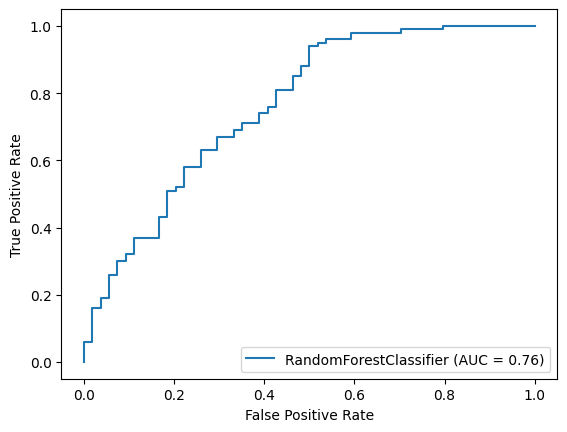

In [15]:
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='RandomForestClassifier')
display.plot()

In [16]:
# MEN Train

In [17]:
all_data_men_train = X_train
all_data_men_train["Paidback"] = y_train
X_men_train=all_data_men_train[all_data_men_train.Gender == 1]
y_men_train=X_men_train.Paidback
X_men_train = X_men_train.drop(columns=["Paidback"])

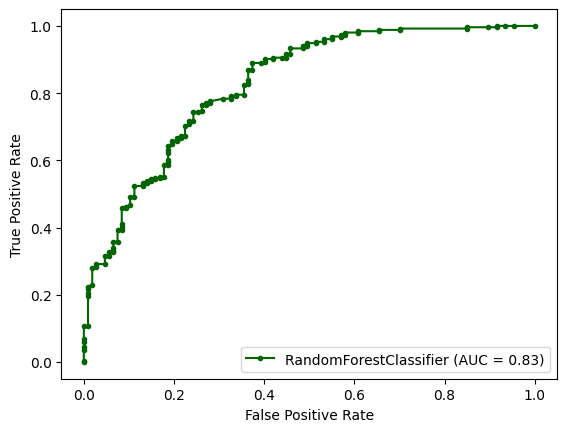

In [18]:
y_pred_proba_men_train = optuna_search.predict_proba(X_men_train)
roc_auc_score(y_men_train, y_pred_proba_men_train[:, 1])
fpr_men_train, tpr_men_train, thresholds_men_train = roc_curve(y_men_train, y_pred_proba_men_train[:, 1])
roc_auc_men_train = auc(fpr_men_train, tpr_men_train)
#print(thresholds_men_train[np.argmax(tpr_men_train - tpr_women_train)])
display_men_train = RocCurveDisplay(fpr=fpr_men_train, tpr=tpr_men_train, roc_auc=roc_auc_men_train, estimator_name='RandomForestClassifier')
display_men_train.plot(marker='.', color="darkgreen")

In [19]:
# MEN Test

In [20]:
all_data_men_test = X_test
all_data_men_test["Paidback"] = y_test
X_men_test=all_data_men_test[all_data_men_test.Gender == 1]
y_men_test=X_men_test.Paidback
X_men_test = X_men_test.drop(columns=["Paidback"])

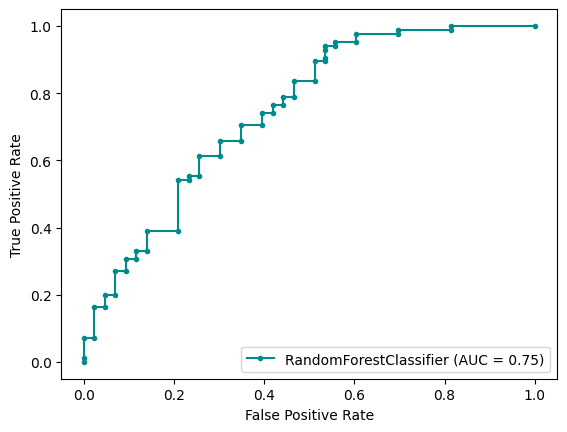

In [21]:
y_pred_proba_men_test = optuna_search.predict_proba(X_men_test)
roc_auc_score(y_men_test, y_pred_proba_men_test[:, 1])
fpr_men_test, tpr_men_test, thresholds_men_test = roc_curve(y_men_test, y_pred_proba_men_test[:, 1])
roc_auc_men_test = auc(fpr_men_test, tpr_men_test)
display_men_test = RocCurveDisplay(fpr=fpr_men_test, tpr=tpr_men_test, roc_auc=roc_auc_men_test, estimator_name='RandomForestClassifier')
display_men_test.plot(marker='.', color="darkcyan")

In [22]:
# Women Train

In [23]:
all_data_women_train = X_train
all_data_women_train["Paidback"] = y_train
X_women_train=all_data_women_train[all_data_women_train.Gender == 0]
y_women_train=X_women_train.Paidback
X_women_train = X_women_train.drop(columns=["Paidback"])

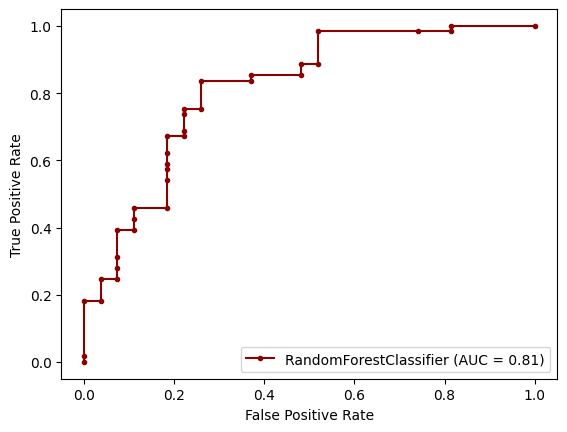

In [24]:
y_pred_proba_women_train = optuna_search.predict_proba(X_women_train)
roc_auc_score(y_women_train, y_pred_proba_women_train[:, 1])
fpr_women_train, tpr_women_train, thresholds_women_train = roc_curve(y_women_train, y_pred_proba_women_train[:, 1])
roc_auc_women_train = auc(fpr_women_train, tpr_women_train)
display_women_train = RocCurveDisplay(fpr=fpr_women_train, tpr=tpr_women_train, roc_auc=roc_auc_women_train, estimator_name='RandomForestClassifier')
display_women_train.plot(marker='.', color='darkred')

In [25]:
# Women Test

In [26]:
all_data_women_test = X_test
all_data_women_test["Paidback"] = y_test
X_women_test=all_data_women_test[all_data_women_test.Gender == 0]
y_women_test=X_women_test.Paidback
X_women_test = X_women_test.drop(columns=["Paidback"])

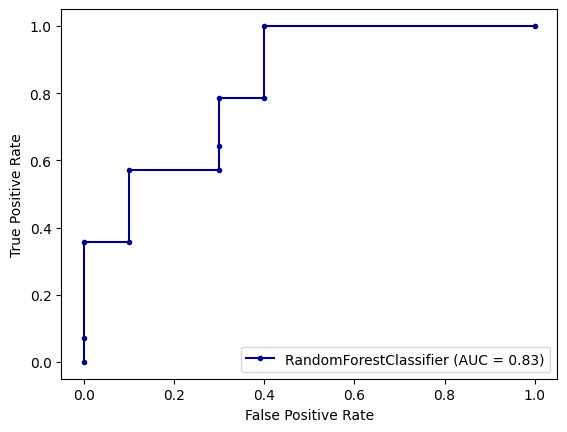

In [27]:
y_pred_proba_women_test = optuna_search.predict_proba(X_women_test)
roc_auc_score(y_women_test, y_pred_proba_women_test[:, 1])
fpr_women_test, tpr_women_test, thresholds_women_test = roc_curve(y_women_test, y_pred_proba_women_test[:, 1])
roc_auc_women_test = auc(fpr_women_test, tpr_women_test)
display_women_test = RocCurveDisplay(fpr=fpr_women_test, tpr=tpr_women_test, roc_auc=roc_auc_women_test, estimator_name='RandomForestClassifier')
display_women_test.plot(marker='.', color='darkblue')

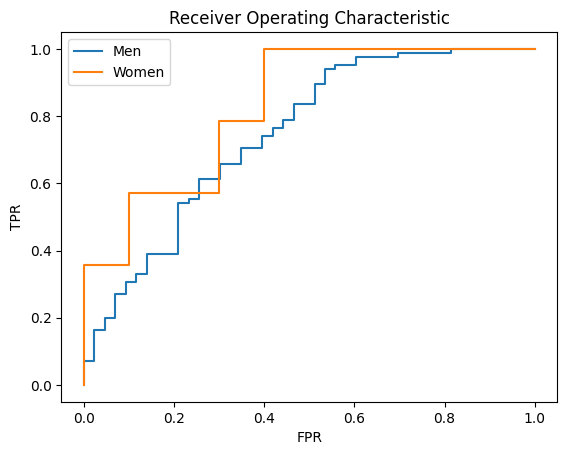

In [28]:
import matplotlib.pyplot as plt
plt.plot(fpr_men_test, tpr_men_test, label= "Men")
plt.plot(fpr_women_test, tpr_women_test, label= "Women")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

In [29]:
women=pd.DataFrame(data=y_pred_proba_women_test, columns=["no_payback", "payback"])
women["real_values"]=y_women_test.reset_index().Paidback
women = women.sort_values(by="payback", ascending=False)

In [30]:
men=pd.DataFrame(data=y_pred_proba_men_test, columns=["no_payback", "payback"])
men["real_values"]=y_men_test.reset_index().Paidback
men = men.sort_values(by="payback", ascending=False)

In [31]:
study_name = "equality_new"  # Unique identifier of the study.
storage_name = "sqlite:///equality_new.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")

[I 2024-01-31 14:14:55,918] A new study created in RDB with name: equality_new


In [32]:
def objective(trial):
    
    threshold_men = trial.suggest_float('threshold_men', low=0.4, high=0.7, step=0.01)
    threshold_women = trial.suggest_float('threshold_women', low=0.4, high=0.7, step=0.01)
    
    yes_loan_men = np.where(men.payback>=threshold_men, 1, 0)
    yes_loan_women = np.where(women.payback>=threshold_women, 1, 0)
    
    tn_men, fp_men, fn_men, tp_men = confusion_matrix(y_true=men.real_values, y_pred=yes_loan_men).ravel()
    tn_women, fp_women, fn_women, tp_women = confusion_matrix(y_true=women.real_values, y_pred=yes_loan_women).ravel()
    
    tpr_men = tp_men/(tp_men+fn_men)
    tpr_women = tp_women/(tp_women+fn_women)
    
    fpr_men = fp_men / (fp_men+tn_men)
    fpr_women = fp_women / (fp_women+tn_women)
    
    
    #Filtering out lazy solutions
    if (tpr_men == 0.0 or tpr_women==0.0) or (tpr_men==1.0 or tpr_women == 1.0): raise optuna.TrialPruned  
    if (tpr_men == 0.0 and tpr_women==0.0) or (tpr_men==1.0 and tpr_women == 1.0): raise optuna.TrialPruned  
    if (fpr_men == 0.0 or fpr_women==0.0) or (fpr_men==1.0 or fpr_women == 1.0): raise optuna.TrialPruned  
    if (fpr_men == 0.0 and fpr_women==0.0) or (fpr_men==1.0 and fpr_women == 1.0): raise optuna.TrialPruned  
    
    print("tpr_women: ", tpr_women)
    print("tpr_men: ", tpr_men)
    minimize = tpr_men-tpr_women
    #since both have to be equal to fulfill the criteria, best solution is 0
    trial.set_user_attr("TPR_MEN", tpr_men)
    trial.set_user_attr("TPR_WOMEN", tpr_women)
    trial.set_user_attr("FPR_MEN", fpr_men)
    trial.set_user_attr("FPR_WOMEN", fpr_women)
    return abs(minimize)

study.optimize(objective, n_trials=500)

df_all = study.trials_dataframe(attrs=("number", "value", "params", "state"))

[I 2024-01-31 14:14:56,019] Trial 0 pruned. 
[I 2024-01-31 14:14:56,133] Trial 1 finished with value: 0.3100840336134453 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.5}. Best is trial 1 with value: 0.3100840336134453.
[I 2024-01-31 14:14:56,236] Trial 2 finished with value: 0.27815126050420175 and parameters: {'threshold_men': 0.5800000000000001, 'threshold_women': 0.5}. Best is trial 2 with value: 0.27815126050420175.


tpr_women:  0.6428571428571429
tpr_men:  0.9529411764705882
tpr_women:  0.6428571428571429
tpr_men:  0.36470588235294116


[I 2024-01-31 14:14:56,298] Trial 3 pruned. 
[I 2024-01-31 14:14:56,361] Trial 4 pruned. 
[I 2024-01-31 14:14:56,423] Trial 5 pruned. 
[I 2024-01-31 14:14:56,489] Trial 6 pruned. 
[I 2024-01-31 14:14:56,593] Trial 7 finished with value: 0.4050420168067227 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.51}. Best is trial 2 with value: 0.27815126050420175.
[I 2024-01-31 14:14:56,654] Trial 8 pruned. 


tpr_women:  0.5714285714285714
tpr_men:  0.9764705882352941
tpr_women:  0.5714285714285714
tpr_men:  0.9764705882352941


[I 2024-01-31 14:14:56,755] Trial 9 finished with value: 0.4050420168067227 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.51}. Best is trial 2 with value: 0.27815126050420175.
[I 2024-01-31 14:14:56,835] Trial 10 pruned. 
[I 2024-01-31 14:14:56,956] Trial 11 finished with value: 0.1739495798319327 and parameters: {'threshold_men': 0.54, 'threshold_women': 0.49}. Best is trial 11 with value: 0.1739495798319327.
[I 2024-01-31 14:14:57,077] Trial 12 finished with value: 0.38739495798319334 and parameters: {'threshold_men': 0.55, 'threshold_women': 0.47000000000000003}. Best is trial 11 with value: 0.1739495798319327.


tpr_women:  0.7857142857142857
tpr_men:  0.611764705882353
tpr_women:  0.9285714285714286
tpr_men:  0.5411764705882353


[I 2024-01-31 14:14:57,159] Trial 13 pruned. 
[I 2024-01-31 14:14:57,237] Trial 14 pruned. 
[I 2024-01-31 14:14:57,361] Trial 15 finished with value: 0.22941176470588232 and parameters: {'threshold_men': 0.52, 'threshold_women': 0.53}. Best is trial 11 with value: 0.1739495798319327.
[I 2024-01-31 14:14:57,441] Trial 16 pruned. 


tpr_women:  0.5
tpr_men:  0.7294117647058823


[I 2024-01-31 14:14:57,564] Trial 17 finished with value: 0.3831932773109244 and parameters: {'threshold_men': 0.51, 'threshold_women': 0.54}. Best is trial 11 with value: 0.1739495798319327.
[I 2024-01-31 14:14:57,642] Trial 18 pruned. 


tpr_women:  0.42857142857142855
tpr_men:  0.8117647058823529


[I 2024-01-31 14:14:57,722] Trial 19 pruned. 
[I 2024-01-31 14:14:57,843] Trial 20 finished with value: 0.5596638655462185 and parameters: {'threshold_men': 0.4, 'threshold_women': 0.54}. Best is trial 11 with value: 0.1739495798319327.
[I 2024-01-31 14:14:57,962] Trial 21 finished with value: 0.42100840336134454 and parameters: {'threshold_men': 0.5800000000000001, 'threshold_women': 0.49}. Best is trial 11 with value: 0.1739495798319327.


tpr_women:  0.42857142857142855
tpr_men:  0.9882352941176471
tpr_women:  0.7857142857142857
tpr_men:  0.36470588235294116


[I 2024-01-31 14:14:58,080] Trial 22 finished with value: 0.22941176470588237 and parameters: {'threshold_men': 0.6000000000000001, 'threshold_women': 0.53}. Best is trial 11 with value: 0.1739495798319327.
[I 2024-01-31 14:14:58,161] Trial 23 pruned. 


tpr_women:  0.5
tpr_men:  0.27058823529411763
tpr_women:  0.35714285714285715
tpr_men:  0.7058823529411765


[I 2024-01-31 14:14:58,291] Trial 24 finished with value: 0.34873949579831937 and parameters: {'threshold_men': 0.53, 'threshold_women': 0.56}. Best is trial 11 with value: 0.1739495798319327.
[I 2024-01-31 14:14:58,379] Trial 25 pruned. 
[I 2024-01-31 14:14:58,464] Trial 26 pruned. 
[I 2024-01-31 14:14:58,596] Trial 27 finished with value: 0.04117647058823526 and parameters: {'threshold_men': 0.55, 'threshold_women': 0.53}. Best is trial 27 with value: 0.04117647058823526.
[I 2024-01-31 14:14:58,682] Trial 28 pruned. 


tpr_women:  0.5
tpr_men:  0.5411764705882353


[I 2024-01-31 14:14:58,806] Trial 29 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 29 with value: 0.03445378151260503.
[I 2024-01-31 14:14:58,888] Trial 30 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:14:59,013] Trial 31 finished with value: 0.2226890756302521 and parameters: {'threshold_men': 0.53, 'threshold_women': 0.48000000000000004}. Best is trial 29 with value: 0.03445378151260503.
[I 2024-01-31 14:14:59,138] Trial 32 finished with value: 0.07983193277310918 and parameters: {'threshold_men': 0.53, 'threshold_women': 0.49}. Best is trial 29 with value: 0.03445378151260503.


tpr_women:  0.9285714285714286
tpr_men:  0.7058823529411765
tpr_women:  0.7857142857142857
tpr_men:  0.7058823529411765


[I 2024-01-31 14:14:59,265] Trial 33 finished with value: 0.3815126050420168 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.51}. Best is trial 29 with value: 0.03445378151260503.
[I 2024-01-31 14:14:59,387] Trial 34 finished with value: 0.3033613445378151 and parameters: {'threshold_men': 0.56, 'threshold_women': 0.49}. Best is trial 29 with value: 0.03445378151260503.


tpr_women:  0.5714285714285714
tpr_men:  0.9529411764705882
tpr_women:  0.7857142857142857
tpr_men:  0.4823529411764706


[I 2024-01-31 14:14:59,471] Trial 35 pruned. 
[I 2024-01-31 14:14:59,592] Trial 36 finished with value: 0.3168067226890756 and parameters: {'threshold_men': 0.54, 'threshold_women': 0.48000000000000004}. Best is trial 29 with value: 0.03445378151260503.
[I 2024-01-31 14:14:59,719] Trial 37 finished with value: 0.20420168067226885 and parameters: {'threshold_men': 0.5, 'threshold_women': 0.5}. Best is trial 29 with value: 0.03445378151260503.


tpr_women:  0.9285714285714286
tpr_men:  0.611764705882353
tpr_women:  0.6428571428571429
tpr_men:  0.8470588235294118


[I 2024-01-31 14:14:59,806] Trial 38 pruned. 
[I 2024-01-31 14:14:59,931] Trial 39 finished with value: 0.28739495798319326 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.52}. Best is trial 29 with value: 0.03445378151260503.
[I 2024-01-31 14:15:00,023] Trial 40 pruned. 


tpr_women:  0.5714285714285714
tpr_men:  0.8588235294117647


[I 2024-01-31 14:15:00,148] Trial 41 finished with value: 0.20420168067226885 and parameters: {'threshold_men': 0.5, 'threshold_women': 0.5}. Best is trial 29 with value: 0.03445378151260503.
[I 2024-01-31 14:15:00,272] Trial 42 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 29 with value: 0.03445378151260503.


tpr_women:  0.6428571428571429
tpr_men:  0.8470588235294118
tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:00,402] Trial 43 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.48000000000000004}. Best is trial 29 with value: 0.03445378151260503.
[I 2024-01-31 14:15:00,530] Trial 44 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.47000000000000003}. Best is trial 29 with value: 0.03445378151260503.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:00,659] Trial 45 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.47000000000000003}. Best is trial 29 with value: 0.03445378151260503.
[I 2024-01-31 14:15:00,741] Trial 46 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:00,862] Trial 47 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 29 with value: 0.03445378151260503.
[I 2024-01-31 14:15:00,939] Trial 48 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:01,018] Trial 49 pruned. 
[I 2024-01-31 14:15:01,136] Trial 50 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:01,257] Trial 51 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:01,338] Trial 52 pruned. 
[I 2024-01-31 14:15:01,463] Trial 53 finished with value: 0.3815126050420168 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.51}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:01,548] Trial 54 pruned. 


tpr_women:  0.5714285714285714
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:01,692] Trial 55 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:01,783] Trial 56 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:01,923] Trial 57 finished with value: 0.4168067226890757 and parameters: {'threshold_men': 0.41000000000000003, 'threshold_women': 0.52}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:02,007] Trial 58 pruned. 


tpr_women:  0.5714285714285714
tpr_men:  0.9882352941176471


[I 2024-01-31 14:15:02,134] Trial 59 finished with value: 0.5369747899159665 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.56}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:02,219] Trial 60 pruned. 


tpr_women:  0.35714285714285715
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:02,347] Trial 61 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.43000000000000005, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:02,436] Trial 62 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:02,526] Trial 63 pruned. 
[I 2024-01-31 14:15:02,660] Trial 64 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:02,748] Trial 65 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:02,885] Trial 66 finished with value: 0.08151260504201685 and parameters: {'threshold_men': 0.5, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:03,016] Trial 67 finished with value: 0.3100840336134453 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8470588235294118
tpr_women:  0.6428571428571429
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:03,159] Trial 68 finished with value: 0.3831932773109244 and parameters: {'threshold_men': 0.51, 'threshold_women': 0.54}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.42857142857142855
tpr_men:  0.8117647058823529
tpr_women:  0.5714285714285714
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:03,305] Trial 69 finished with value: 0.3815126050420168 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.52}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:03,402] Trial 70 pruned. 
[I 2024-01-31 14:15:03,523] Trial 71 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.42000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:03,645] Trial 72 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:03,729] Trial 73 pruned. 
[I 2024-01-31 14:15:03,854] Trial 74 finished with value: 0.3100840336134453 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:03,978] Trial 75 finished with value: 0.07310924369747895 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.6428571428571429
tpr_men:  0.9529411764705882
tpr_women:  0.7857142857142857
tpr_men:  0.8588235294117647


[I 2024-01-31 14:15:04,070] Trial 76 pruned. 
[I 2024-01-31 14:15:04,161] Trial 77 pruned. 
[I 2024-01-31 14:15:04,244] Trial 78 pruned. 
[I 2024-01-31 14:15:04,373] Trial 79 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:04,458] Trial 80 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:04,543] Trial 81 pruned. 
[I 2024-01-31 14:15:04,674] Trial 82 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:04,799] Trial 83 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:04,922] Trial 84 finished with value: 0.4050420168067227 and parameters: {'threshold_men': 0.42000000000000004, 'threshold_women': 0.51}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:05,040] Trial 85 finished with value: 0.21596638655462175 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.5714285714285714
tpr_men:  0.9764705882352941
tpr_women:  0.6428571428571429
tpr_men:  0.8588235294117647


[I 2024-01-31 14:15:05,161] Trial 86 finished with value: 0.49327731092436977 and parameters: {'threshold_men': 0.5700000000000001, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:05,283] Trial 87 finished with value: 0.2747899159663866 and parameters: {'threshold_men': 0.63, 'threshold_women': 0.55}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.43529411764705883
tpr_women:  0.35714285714285715
tpr_men:  0.08235294117647059


[I 2024-01-31 14:15:05,364] Trial 88 pruned. 
[I 2024-01-31 14:15:05,487] Trial 89 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:05,574] Trial 90 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:05,696] Trial 91 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:05,781] Trial 92 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:05,861] Trial 93 pruned. 
[I 2024-01-31 14:15:05,943] Trial 94 pruned. 
[I 2024-01-31 14:15:06,065] Trial 95 finished with value: 0.1991596638655463 and parameters: {'threshold_men': 0.52, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:06,188] Trial 96 finished with value: 0.1907563025210084 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.7294117647058823
tpr_women:  0.7857142857142857
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:06,313] Trial 97 finished with value: 0.1907563025210084 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:06,436] Trial 98 finished with value: 0.4050420168067227 and parameters: {'threshold_men': 0.42000000000000004, 'threshold_women': 0.51}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.9764705882352941
tpr_women:  0.5714285714285714
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:06,563] Trial 99 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:06,648] Trial 100 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:06,772] Trial 101 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:06,893] Trial 102 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:07,013] Trial 103 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:07,094] Trial 104 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.6428571428571429
tpr_men:  0.8588235294117647


[I 2024-01-31 14:15:07,218] Trial 105 finished with value: 0.21596638655462175 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:07,343] Trial 106 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:07,472] Trial 107 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:07,599] Trial 108 finished with value: 0.026050420168067245 and parameters: {'threshold_men': 0.51, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:07,724] Trial 109 finished with value: 0.026050420168067245 and parameters: {'threshold_men': 0.51, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.8117647058823529
tpr_women:  0.7857142857142857
tpr_men:  0.8117647058823529


[I 2024-01-31 14:15:07,849] Trial 110 finished with value: 0.026050420168067245 and parameters: {'threshold_men': 0.51, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:07,971] Trial 111 finished with value: 0.026050420168067245 and parameters: {'threshold_men': 0.51, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.8117647058823529
tpr_women:  0.7857142857142857
tpr_men:  0.8117647058823529


[I 2024-01-31 14:15:08,097] Trial 112 finished with value: 0.026050420168067245 and parameters: {'threshold_men': 0.51, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:08,224] Trial 113 finished with value: 0.031092436974789917 and parameters: {'threshold_men': 0.54, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.8117647058823529
tpr_women:  0.6428571428571429
tpr_men:  0.611764705882353


[I 2024-01-31 14:15:08,352] Trial 114 finished with value: 0.026050420168067245 and parameters: {'threshold_men': 0.51, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:08,479] Trial 115 finished with value: 0.08151260504201685 and parameters: {'threshold_men': 0.5, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.8117647058823529
tpr_women:  0.9285714285714286
tpr_men:  0.8470588235294118


[I 2024-01-31 14:15:08,606] Trial 116 finished with value: 0.13445378151260512 and parameters: {'threshold_men': 0.53, 'threshold_women': 0.52}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:08,732] Trial 117 finished with value: 0.15798319327731092 and parameters: {'threshold_men': 0.52, 'threshold_women': 0.51}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.5714285714285714
tpr_men:  0.7058823529411765
tpr_women:  0.5714285714285714
tpr_men:  0.7294117647058823


[I 2024-01-31 14:15:08,816] Trial 118 pruned. 
[I 2024-01-31 14:15:08,938] Trial 119 finished with value: 0.061344537815126055 and parameters: {'threshold_men': 0.5, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:09,065] Trial 120 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.8470588235294118
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:09,190] Trial 121 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:09,313] Trial 122 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:09,437] Trial 123 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:09,563] Trial 124 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:09,650] Trial 125 pruned. 
[I 2024-01-31 14:15:09,780] Trial 126 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:09,864] Trial 127 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:09,946] Trial 128 pruned. 
[I 2024-01-31 14:15:10,063] Trial 129 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:10,146] Trial 130 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:10,271] Trial 131 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:10,398] Trial 132 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:10,525] Trial 133 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:10,612] Trial 134 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:10,742] Trial 135 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:10,829] Trial 136 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:10,956] Trial 137 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:11,080] Trial 138 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:11,167] Trial 139 pruned. 
[I 2024-01-31 14:15:11,297] Trial 140 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:11,380] Trial 141 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:11,507] Trial 142 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:11,591] Trial 143 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:11,721] Trial 144 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:11,851] Trial 145 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:11,936] Trial 146 pruned. 
[I 2024-01-31 14:15:12,062] Trial 147 finished with value: 0.06974789915966395 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:12,188] Trial 148 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8588235294117647
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:12,274] Trial 149 pruned. 
[I 2024-01-31 14:15:12,362] Trial 150 pruned. 
[I 2024-01-31 14:15:12,486] Trial 151 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:12,615] Trial 152 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:12,747] Trial 153 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:12,878] Trial 154 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:12,976] Trial 155 pruned. 
[I 2024-01-31 14:15:13,109] Trial 156 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:13,198] Trial 157 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:13,328] Trial 158 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:13,417] Trial 159 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:13,509] Trial 160 pruned. 
[I 2024-01-31 14:15:13,640] Trial 161 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:13,769] Trial 162 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:13,894] Trial 163 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:14,020] Trial 164 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:14,112] Trial 165 pruned. 
[I 2024-01-31 14:15:14,243] Trial 166 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:14,373] Trial 167 finished with value: 0.3336134453781512 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.6428571428571429
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:14,504] Trial 168 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:14,640] Trial 169 finished with value: 0.10840336134453787 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.7857142857142857
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:14,783] Trial 170 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:14,917] Trial 171 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:15,005] Trial 172 pruned. 
[I 2024-01-31 14:15:15,132] Trial 173 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:15,263] Trial 174 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:15,351] Trial 175 pruned. 
[I 2024-01-31 14:15:15,483] Trial 176 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:15,571] Trial 177 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:15,709] Trial 178 finished with value: 0.07310924369747895 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:15,841] Trial 179 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.8588235294117647
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:15,972] Trial 180 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:16,101] Trial 181 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:16,229] Trial 182 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:16,315] Trial 183 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:16,441] Trial 184 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:16,573] Trial 185 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:16,702] Trial 186 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:16,830] Trial 187 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:16,917] Trial 188 pruned. 
[I 2024-01-31 14:15:17,001] Trial 189 pruned. 
[I 2024-01-31 14:15:17,128] Trial 190 finished with value: 0.3100840336134453 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:17,260] Trial 191 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.6428571428571429
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:17,386] Trial 192 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:17,520] Trial 193 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:17,651] Trial 194 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:17,784] Trial 195 finished with value: 0.06974789915966395 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8588235294117647


[I 2024-01-31 14:15:17,872] Trial 196 pruned. 
[I 2024-01-31 14:15:17,956] Trial 197 pruned. 
[I 2024-01-31 14:15:18,042] Trial 198 pruned. 
[I 2024-01-31 14:15:18,164] Trial 199 finished with value: 0.10840336134453787 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:18,291] Trial 200 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:18,415] Trial 201 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:18,539] Trial 202 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:18,664] Trial 203 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:18,786] Trial 204 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:18,915] Trial 205 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:19,040] Trial 206 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:19,170] Trial 207 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:19,256] Trial 208 pruned. 


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:19,382] Trial 209 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:19,509] Trial 210 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:19,635] Trial 211 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:19,722] Trial 212 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:19,856] Trial 213 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:19,984] Trial 214 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:20,072] Trial 215 pruned. 
[I 2024-01-31 14:15:20,198] Trial 216 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:20,328] Trial 217 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:20,462] Trial 218 finished with value: 0.10840336134453787 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:20,590] Trial 219 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:20,720] Trial 220 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:20,845] Trial 221 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:20,931] Trial 222 pruned. 
[I 2024-01-31 14:15:21,056] Trial 223 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:21,181] Trial 224 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:21,272] Trial 225 pruned. 
[I 2024-01-31 14:15:21,398] Trial 226 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:21,525] Trial 227 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:21,655] Trial 228 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:21,783] Trial 229 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:21,873] Trial 230 pruned. 
[I 2024-01-31 14:15:21,998] Trial 231 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:22,088] Trial 232 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:22,214] Trial 233 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:22,338] Trial 234 finished with value: 0.1907563025210084 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.7857142857142857
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:22,463] Trial 235 finished with value: 0.657983193277311 and parameters: {'threshold_men': 0.6000000000000001, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:22,591] Trial 236 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.27058823529411763
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:22,678] Trial 237 pruned. 
[I 2024-01-31 14:15:22,801] Trial 238 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:22,935] Trial 239 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:23,026] Trial 240 pruned. 
[I 2024-01-31 14:15:23,152] Trial 241 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:23,284] Trial 242 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:23,416] Trial 243 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:23,542] Trial 244 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:23,674] Trial 245 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:23,800] Trial 246 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:23,930] Trial 247 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:24,059] Trial 248 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:24,146] Trial 249 pruned. 
[I 2024-01-31 14:15:24,274] Trial 250 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:24,403] Trial 251 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:24,530] Trial 252 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:24,664] Trial 253 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:24,756] Trial 254 pruned. 
[I 2024-01-31 14:15:24,890] Trial 255 finished with value: 0.06974789915966395 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:25,021] Trial 256 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8588235294117647
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:25,149] Trial 257 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:25,239] Trial 258 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:25,331] Trial 259 pruned. 
[I 2024-01-31 14:15:25,466] Trial 260 finished with value: 0.446218487394958 and parameters: {'threshold_men': 0.56, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:25,603] Trial 261 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.4823529411764706
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:25,743] Trial 262 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:25,885] Trial 263 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:25,976] Trial 264 pruned. 
[I 2024-01-31 14:15:26,069] Trial 265 pruned. 
[I 2024-01-31 14:15:26,209] Trial 266 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:26,342] Trial 267 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:26,479] Trial 268 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:26,613] Trial 269 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:26,704] Trial 270 pruned. 
[I 2024-01-31 14:15:26,795] Trial 271 pruned. 
[I 2024-01-31 14:15:26,928] Trial 272 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:27,063] Trial 273 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:27,156] Trial 274 pruned. 
[I 2024-01-31 14:15:27,287] Trial 275 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:27,423] Trial 276 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:27,558] Trial 277 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:27,693] Trial 278 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:27,834] Trial 279 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:27,927] Trial 280 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:28,062] Trial 281 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:28,199] Trial 282 finished with value: 0.25126050420168067 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.6428571428571429
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:28,341] Trial 283 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:28,436] Trial 284 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:28,579] Trial 285 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.35714285714285715
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:28,721] Trial 286 finished with value: 0.5369747899159665 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.55}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:28,815] Trial 287 pruned. 
[I 2024-01-31 14:15:28,959] Trial 288 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:29,056] Trial 289 pruned. 


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:29,204] Trial 290 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:29,302] Trial 291 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:29,447] Trial 292 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:29,542] Trial 293 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:29,694] Trial 294 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:29,839] Trial 295 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:29,986] Trial 296 finished with value: 0.07310924369747895 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.8588235294117647
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:30,128] Trial 297 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:30,226] Trial 298 pruned. 
[I 2024-01-31 14:15:30,320] Trial 299 pruned. 
[I 2024-01-31 14:15:30,465] Trial 300 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:30,607] Trial 301 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:30,750] Trial 302 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:30,889] Trial 303 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:30,986] Trial 304 pruned. 
[I 2024-01-31 14:15:31,125] Trial 305 finished with value: 0.10840336134453787 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:31,260] Trial 306 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:31,394] Trial 307 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:31,486] Trial 308 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:31,631] Trial 309 finished with value: 0.3336134453781512 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.6428571428571429
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:31,775] Trial 310 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:31,870] Trial 311 pruned. 
[I 2024-01-31 14:15:32,013] Trial 312 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:32,106] Trial 313 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:32,247] Trial 314 finished with value: 0.1907563025210084 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:32,380] Trial 315 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:32,523] Trial 316 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:32,657] Trial 317 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:32,751] Trial 318 pruned. 
[I 2024-01-31 14:15:32,889] Trial 319 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:33,028] Trial 320 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:33,123] Trial 321 pruned. 
[I 2024-01-31 14:15:33,263] Trial 322 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:33,403] Trial 323 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:33,500] Trial 324 pruned. 
[I 2024-01-31 14:15:33,598] Trial 325 pruned. 
[I 2024-01-31 14:15:33,735] Trial 326 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:33,867] Trial 327 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:33,961] Trial 328 pruned. 
[I 2024-01-31 14:15:34,102] Trial 329 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.43000000000000005, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.7857142857142857
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:34,244] Trial 330 finished with value: 0.1907563025210084 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:34,340] Trial 331 pruned. 
[I 2024-01-31 14:15:34,435] Trial 332 pruned. 
[I 2024-01-31 14:15:34,575] Trial 333 finished with value: 0.06974789915966395 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:34,714] Trial 334 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8588235294117647
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:34,819] Trial 335 pruned. 
[I 2024-01-31 14:15:34,959] Trial 336 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:35,091] Trial 337 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:35,185] Trial 338 pruned. 
[I 2024-01-31 14:15:35,318] Trial 339 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:35,447] Trial 340 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:35,584] Trial 341 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:35,679] Trial 342 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:35,817] Trial 343 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:35,947] Trial 344 finished with value: 0.4529411764705882 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.53}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.5
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:36,083] Trial 345 finished with value: 0.21596638655462175 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:36,173] Trial 346 pruned. 


tpr_women:  0.6428571428571429
tpr_men:  0.8588235294117647


[I 2024-01-31 14:15:36,261] Trial 347 pruned. 
[I 2024-01-31 14:15:36,387] Trial 348 finished with value: 0.6226890756302521 and parameters: {'threshold_men': 0.5900000000000001, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:36,514] Trial 349 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.3058823529411765
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:36,646] Trial 350 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:36,777] Trial 351 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:36,866] Trial 352 pruned. 
[I 2024-01-31 14:15:36,997] Trial 353 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:37,126] Trial 354 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:37,257] Trial 355 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:37,387] Trial 356 finished with value: 0.3168067226890756 and parameters: {'threshold_men': 0.54, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.611764705882353


[I 2024-01-31 14:15:37,482] Trial 357 pruned. 
[I 2024-01-31 14:15:37,618] Trial 358 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:37,754] Trial 359 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:37,849] Trial 360 pruned. 
[I 2024-01-31 14:15:37,981] Trial 361 finished with value: 0.1907563025210084 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:38,071] Trial 362 pruned. 


tpr_women:  0.7857142857142857
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:38,200] Trial 363 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:38,333] Trial 364 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:38,465] Trial 365 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:38,599] Trial 366 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:38,732] Trial 367 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:38,823] Trial 368 pruned. 


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:38,961] Trial 369 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:39,092] Trial 370 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:39,228] Trial 371 finished with value: 0.06974789915966395 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:39,364] Trial 372 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8588235294117647
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:39,461] Trial 373 pruned. 
[I 2024-01-31 14:15:39,598] Trial 374 finished with value: 0.1907563025210084 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:39,695] Trial 375 pruned. 


tpr_women:  0.7857142857142857
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:39,835] Trial 376 finished with value: 0.25126050420168067 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:39,971] Trial 377 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.6428571428571429
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:40,063] Trial 378 pruned. 
[I 2024-01-31 14:15:40,199] Trial 379 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:40,336] Trial 380 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:40,431] Trial 381 pruned. 
[I 2024-01-31 14:15:40,570] Trial 382 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:40,705] Trial 383 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:40,803] Trial 384 pruned. 
[I 2024-01-31 14:15:40,944] Trial 385 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.43529411764705883


[I 2024-01-31 14:15:41,090] Trial 386 finished with value: 0.49327731092436977 and parameters: {'threshold_men': 0.5700000000000001, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:41,186] Trial 387 pruned. 
[I 2024-01-31 14:15:41,322] Trial 388 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:41,457] Trial 389 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:41,598] Trial 390 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:41,696] Trial 391 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:41,792] Trial 392 pruned. 
[I 2024-01-31 14:15:41,934] Trial 393 finished with value: 0.07310924369747895 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:42,032] Trial 394 pruned. 


tpr_women:  0.7857142857142857
tpr_men:  0.8588235294117647


[I 2024-01-31 14:15:42,171] Trial 395 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:42,266] Trial 396 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:42,365] Trial 397 pruned. 
[I 2024-01-31 14:15:42,509] Trial 398 finished with value: 0.3815126050420168 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.51}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:42,605] Trial 399 pruned. 


tpr_women:  0.5714285714285714
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:42,747] Trial 400 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:42,893] Trial 401 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.43000000000000005, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:42,990] Trial 402 pruned. 
[I 2024-01-31 14:15:43,128] Trial 403 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:43,265] Trial 404 finished with value: 0.25126050420168067 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.6428571428571429
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:43,411] Trial 405 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:43,546] Trial 406 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:43,641] Trial 407 pruned. 
[I 2024-01-31 14:15:43,776] Trial 408 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:43,915] Trial 409 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:44,014] Trial 410 pruned. 
[I 2024-01-31 14:15:44,161] Trial 411 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:44,258] Trial 412 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:44,402] Trial 413 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:44,541] Trial 414 finished with value: 0.10840336134453787 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.7857142857142857
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:44,687] Trial 415 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:44,788] Trial 416 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:44,932] Trial 417 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:45,033] Trial 418 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:45,173] Trial 419 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:45,320] Trial 420 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:45,463] Trial 421 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:45,561] Trial 422 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:45,705] Trial 423 finished with value: 0.1907563025210084 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:45,849] Trial 424 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:45,990] Trial 425 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:46,133] Trial 426 finished with value: 0.06974789915966395 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8588235294117647


[I 2024-01-31 14:15:46,276] Trial 427 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:46,373] Trial 428 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:46,512] Trial 429 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:46,609] Trial 430 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:46,748] Trial 431 finished with value: 0.38739495798319334 and parameters: {'threshold_men': 0.55, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:46,887] Trial 432 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.5411764705882353
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:46,987] Trial 433 pruned. 
[I 2024-01-31 14:15:47,123] Trial 434 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:47,264] Trial 435 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:47,403] Trial 436 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:47,542] Trial 437 finished with value: 0.595798319327731 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.56}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.35714285714285715
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:47,683] Trial 438 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:47,823] Trial 439 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:47,959] Trial 440 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:48,049] Trial 441 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:48,184] Trial 442 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:48,282] Trial 443 pruned. 


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:48,410] Trial 444 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:48,548] Trial 445 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:48,642] Trial 446 pruned. 
[I 2024-01-31 14:15:48,735] Trial 447 pruned. 
[I 2024-01-31 14:15:48,873] Trial 448 finished with value: 0.3336134453781512 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.6428571428571429
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.24705882352941178


[I 2024-01-31 14:15:49,020] Trial 449 finished with value: 0.6815126050420168 and parameters: {'threshold_men': 0.61, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:49,168] Trial 450 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:49,321] Trial 451 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:49,419] Trial 452 pruned. 
[I 2024-01-31 14:15:49,557] Trial 453 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:49,697] Trial 454 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:49,845] Trial 455 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:49,986] Trial 456 finished with value: 0.06974789915966395 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.8588235294117647


[I 2024-01-31 14:15:50,125] Trial 457 finished with value: 0.25126050420168067 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.5}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:50,266] Trial 458 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.6428571428571429
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:50,364] Trial 459 pruned. 
[I 2024-01-31 14:15:50,504] Trial 460 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:50,646] Trial 461 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:50,791] Trial 462 finished with value: 0.1907563025210084 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:50,886] Trial 463 pruned. 


tpr_women:  0.7857142857142857
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:50,984] Trial 464 pruned. 
[I 2024-01-31 14:15:51,082] Trial 465 pruned. 
[I 2024-01-31 14:15:51,218] Trial 466 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:51,354] Trial 467 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:51,490] Trial 468 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:51,631] Trial 469 finished with value: 0.1991596638655463 and parameters: {'threshold_men': 0.52, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.7294117647058823


[I 2024-01-31 14:15:51,775] Trial 470 finished with value: 0.3815126050420168 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.52}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.5714285714285714
tpr_men:  0.9529411764705882
tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:51,920] Trial 471 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:52,062] Trial 472 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:52,200] Trial 473 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:52,296] Trial 474 pruned. 
[I 2024-01-31 14:15:52,429] Trial 475 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:52,563] Trial 476 finished with value: 0.10840336134453787 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.7857142857142857
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:52,659] Trial 477 pruned. 
[I 2024-01-31 14:15:52,796] Trial 478 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:52,934] Trial 479 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:53,034] Trial 480 pruned. 
[I 2024-01-31 14:15:53,132] Trial 481 pruned. 
[I 2024-01-31 14:15:53,269] Trial 482 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:53,415] Trial 483 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:53,564] Trial 484 finished with value: 0.16722689075630248 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.7857142857142857
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:53,713] Trial 485 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:53,817] Trial 486 pruned. 
[I 2024-01-31 14:15:53,959] Trial 487 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.45, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:54,101] Trial 488 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:54,247] Trial 489 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:54,346] Trial 490 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236


[I 2024-01-31 14:15:54,486] Trial 491 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:54,621] Trial 492 finished with value: 0.04789915966386549 and parameters: {'threshold_men': 0.44, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882
tpr_women:  0.9285714285714286
tpr_men:  0.9764705882352941


[I 2024-01-31 14:15:54,718] Trial 493 pruned. 
[I 2024-01-31 14:15:54,856] Trial 494 finished with value: 0.07310924369747895 and parameters: {'threshold_men': 0.49, 'threshold_women': 0.49}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:54,955] Trial 495 pruned. 


tpr_women:  0.7857142857142857
tpr_men:  0.8588235294117647


[I 2024-01-31 14:15:55,094] Trial 496 finished with value: 0.03445378151260503 and parameters: {'threshold_men': 0.48000000000000004, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:55,233] Trial 497 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.46, 'threshold_women': 0.47000000000000003}. Best is trial 50 with value: 0.024369747899159577.


tpr_women:  0.9285714285714286
tpr_men:  0.8941176470588236
tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


[I 2024-01-31 14:15:55,367] Trial 498 finished with value: 0.024369747899159577 and parameters: {'threshold_men': 0.47000000000000003, 'threshold_women': 0.48000000000000004}. Best is trial 50 with value: 0.024369747899159577.
[I 2024-01-31 14:15:55,465] Trial 499 pruned. 


tpr_women:  0.9285714285714286
tpr_men:  0.9529411764705882


In [33]:
list_of_tprs = [study.trials[iuseiasindex].user_attrs for iuseiasindex in range(0, len(df_all))]
df_rates = pd.DataFrame(list_of_tprs)
df_complete=df_all.join(df_rates)

In [34]:
df_complete.sort_values("value")

,number,value,params_threshold_men,params_threshold_women,state,FPR_MEN,FPR_WOMEN,TPR_MEN,TPR_WOMEN
498,498,0.02437,0.47,0.48,COMPLETE,0.581395,0.4,0.952941,0.928571
181,181,0.02437,0.47,0.48,COMPLETE,0.581395,0.4,0.952941,0.928571
182,182,0.02437,0.47,0.48,COMPLETE,0.581395,0.4,0.952941,0.928571
184,184,0.02437,0.47,0.47,COMPLETE,0.581395,0.4,0.952941,0.928571
187,187,0.02437,0.46,0.47,COMPLETE,0.581395,0.4,0.952941,0.928571
...,...,...,...,...,...,...,...,...,...
486,486,NaN,0.46,0.45,PRUNED,NaN,NaN,NaN,NaN
490,490,NaN,0.46,0.46,PRUNED,NaN,NaN,NaN,NaN
493,493,NaN,0.53,0.46,PRUNED,NaN,NaN,NaN,NaN
495,495,NaN,0.46,0.45,PRUNED,NaN,NaN,NaN,NaN


In [35]:
#0/0 and 1/1 is lazy
#but just following the line of the women it is 0.625(also visible because we have 2 points exactly after each other

In [ ]:
fpr_women_test, tpr_women_test, thresholds_women_test = roc_curve(y_women_test, y_pred_proba_women_test[:, 1])
fpr_men_test, tpr_men_test, thresholds_men_test = roc_curve(y_men_test, y_pred_proba_men_test[:, 1])

In [ ]:
# equality of Odds
# not possible with discrete steps, so we make it continous by curve fitting

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [128]:
def func(x, k, b):
    return  np.log(2 * k * x + 1) / np.log(b * k + 1)

xdata = fpr_men_test
ydata = tpr_men_test
popt, pcov = curve_fit(func, xdata, ydata)

In [129]:
def func_2(x, k, b):
    return  np.log(2 * k * x + 1) / np.log(b * k + 1)

xdata_2 = fpr_women_test
ydata_2 = tpr_women_test
popt_2, pcov_2 = curve_fit(func_2, xdata_2, ydata_2)

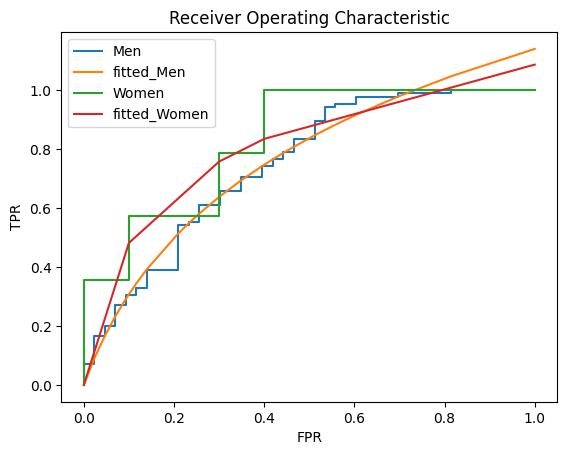

In [130]:
import matplotlib.pyplot as plt
plt.plot(fpr_men_test, tpr_men_test, label= "Men")
plt.plot(fpr_men_test,  np.log(2 * popt[0] * fpr_men_test + 1) / np.log(popt[1] * popt[0] + 1), label= "fitted_Men")

plt.plot(fpr_women_test, tpr_women_test, label= "Women")
plt.plot(fpr_women_test, np.log(2 * popt_2[0] * fpr_women_test + 1) / np.log(popt[1] * popt_2[0] + 1), label= "fitted_Women")

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()